# normal_model

## time pyd_data

In [ ]:
# ================== 1️⃣ 导入路径与函数 ==================
%run ../_init_path.py

# ==============================================================
#  my_CIL_V1/pre_train/KAIST_normal_model/train_normal_pretrain.ipynb
# ==============================================================
import os
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

# === 导入模型结构 ===
from models import GraphContrastiveLearner, augment_graph, summarize_graph
# ↑ 请将此路径修改为你上面提供模型代码所在文件的相对导入路径，例如:
# from models.graph_contrastive import GraphContrastiveLearner, augment_graph, summarize_graph

# ===================== 1️⃣ 基本设置 =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
graph_path = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/mixed_allclass/pyg_data/time/mixed_allclass_arabic_graph_withmask.pt"  # 👈 替换为你的路径
save_dir = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model/model_save/time"
os.makedirs(save_dir, exist_ok=True)

# ===================== 2️⃣ 加载 PyG 图数据 =====================
data = torch.load(graph_path)
data = data.to(device)
summarize_graph(data)

# ===================== 3️⃣ 生成两份增强视图 =====================
data1 = augment_graph(data, feature_drop_prob=0.2, edge_drop_prob=0.1, noise_std=0.02)
data2 = augment_graph(data, feature_drop_prob=0.2, edge_drop_prob=0.1, noise_std=0.02)
data1, data2 = data1.to(device), data2.to(device)

# ===================== 4️⃣ 初始化模型 =====================
in_dim = data.x.size(1)
hidden_dim = 128
out_dim = 128
proj_dim = 64
tau = 0.5

model = GraphContrastiveLearner(in_dim, hidden_dim, out_dim, proj_dim, tau).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# ===================== 5️⃣ 训练循环 =====================
epochs = 200
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()

    loss = model.compute_loss(data1.x, data1.edge_index, data2.x, data2.edge_index)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch [{epoch:03d}/{epochs}] | InfoNCE Loss: {loss.item():.4f}")

# ===================== 6️⃣ 保存模型 =====================
save_path = os.path.join(save_dir, f"KAIST_normal_pretrain_epoch{epochs}.pt")
torch.save({
    "model_state_dict": model.state_dict(),
    "config": {
        "in_dim": in_dim,
        "hidden_dim": hidden_dim,
        "out_dim": out_dim,
        "proj_dim": proj_dim,
        "tau": tau
    }
}, save_path)

print(f"\n✅ 模型已保存至: {save_path}")


## 效果可视化

✅ 已添加路径：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model
✅ 已添加 my_lib：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model/src
✅ 模型加载完成！
⚠️ 未检测到有效的标签 data.y，将使用全零标签代替。
🧩 嵌入维度: (2500, 64)
🧩 嵌入维度: (2500, 64)


/tmp/ipykernel_2828911/966953719.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(graph_path)
/tmp/ipykernel_2828911/966953719.py:33: FutureWarning: Yo

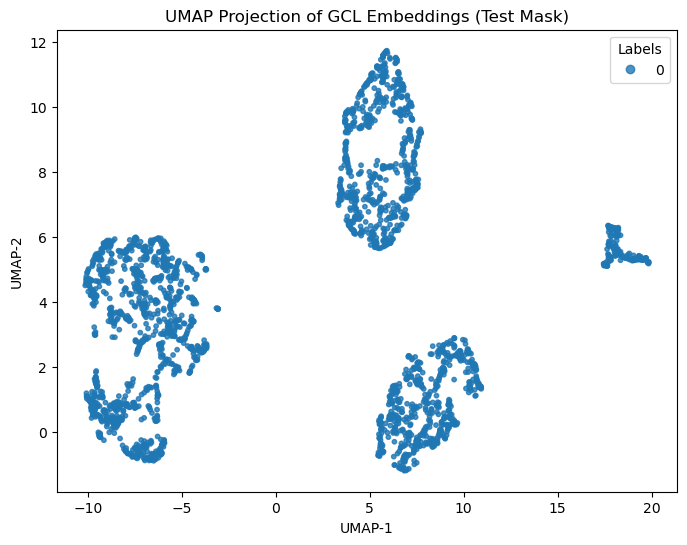

📈 嵌入可视化图已保存：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model/result/time/KAIST_normal_umap.png
🔍 GCL 表征性能指标：
            silhouette: N/A
             mean_norm: 1.3123
              std_norm: 1.0935
    feature_uniformity: 0.0440

✅ 全部结果已保存到：/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model/result/time


In [2]:
# ================== 1️⃣ 导入路径与函数 ==================
%run ../_init_path.py

# ==============================================================
#  my_CIL_V1/pre_train/KAIST_normal_model/eval_normal_embeddings.ipynb
# ==============================================================
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import umap
from torch_geometric.data import Data

# === 导入模型定义 ===
from models import GraphContrastiveLearner, augment_graph, summarize_graph
# 👆 请改为你的实际模型定义文件路径
# 例如: from my_CIL_V1.src.models.graph_contrastive import GraphContrastiveLearner

# ===================== 1️⃣ 参数与路径设置 =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

graph_path = "/home/charles/HZU/Data_processed/my_CIL_V1/KAIST/mixed_allclass/pyg_data/time/mixed_allclass_arabic_graph_withmask.pt"  # 👈 替换为你的路径
model_path = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model/model_save/time/KAIST_normal_pretrain_epoch200.pt"  # 👈 模型路径
save_dir = "/home/charles/HZU/Industrial_Software_Testing/Industrial_Software_Testing/my_CIL_V1/GCL_pre_train/KAIST_normal_model/result/time"
os.makedirs(save_dir, exist_ok=True)

# ===================== 2️⃣ 加载图数据与模型 =====================
data = torch.load(graph_path)
data = data.to(device)

checkpoint = torch.load(model_path, map_location=device)
cfg = checkpoint["config"]

model = GraphContrastiveLearner(**cfg).to(device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("✅ 模型加载完成！")

# ===================== 3️⃣ 提取嵌入 =====================
with torch.no_grad():
    h, z = model(data.x, data.edge_index)  # h=编码特征, z=投影特征

# 只保留 test_mask 下的节点
mask = data.test_mask.cpu().numpy()

embeddings = z.cpu().numpy()[mask]

# ---- 判断 y 是否存在且有效 ----
if hasattr(data, "y") and data.y is not None:
    labels = data.y.cpu().numpy()[mask]
else:
    labels = np.zeros(mask.sum(), dtype=int)
    print("⚠️ 未检测到有效的标签 data.y，将使用全零标签代替。")

print(f"🧩 嵌入维度: {embeddings.shape}")


print(f"🧩 嵌入维度: {embeddings.shape}")

# ===================== 4️⃣ UMAP 降维 =====================
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
emb_2d = reducer.fit_transform(embeddings)

# ===================== 5️⃣ 绘制嵌入图 =====================
plt.figure(figsize=(8,6))
if labels is not None:
    scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='tab10', s=10, alpha=0.8)
    plt.legend(*scatter.legend_elements(), title="Labels", loc="best")
else:
    plt.scatter(emb_2d[:,0], emb_2d[:,1], s=10, alpha=0.8)

plt.title("UMAP Projection of GCL Embeddings (Test Mask)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")

fig_path = os.path.join(save_dir, "KAIST_normal_umap.png")
plt.savefig(fig_path, dpi=300)
plt.show()
print(f"📈 嵌入可视化图已保存：{fig_path}")

# ===================== 6️⃣ 计算表征性能指标 =====================
def compute_gcl_metrics(embeddings, labels):
    """
    计算与GCL表征质量相关的几项指标：
      - Silhouette Score（类内/类间紧凑性）
      - 维度方差均匀性（均匀性度）
      - 向量范数统计
    """
    results = {}
    if labels is not None and len(np.unique(labels)) > 1:
        results["silhouette"] = float(silhouette_score(embeddings, labels))
    else:
        results["silhouette"] = None

    norms = np.linalg.norm(embeddings, axis=1)
    results["mean_norm"] = float(norms.mean())
    results["std_norm"] = float(norms.std())

    var_per_dim = np.var(embeddings, axis=0)
    results["feature_uniformity"] = float(var_per_dim.mean())

    return results

metrics = compute_gcl_metrics(embeddings, labels)
print("🔍 GCL 表征性能指标：")
for k, v in metrics.items():
    print(f"  {k:>20s}: {v:.4f}" if v is not None else f"  {k:>20s}: N/A")

# ===================== 7️⃣ 保存结果 =====================
np.save(os.path.join(save_dir, "KAIST_normal_emb_test.npy"), embeddings)
np.save(os.path.join(save_dir, "KAIST_normal_umap_test.npy"), emb_2d)
with open(os.path.join(save_dir, "KAIST_normal_metrics.txt"), "w") as f:
    for k, v in metrics.items():
        f.write(f"{k}: {v}\n")

print(f"\n✅ 全部结果已保存到：{save_dir}")
